<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

Python implementation: CPython
Python version       : 3.8.9
IPython version      : 8.12.0

numpy      : 1.24.2
scipy      : 1.10.1
pandas     : 2.0.0
matplotlib : 3.7.1
statsmodels: 0.13.5
sklearn    : not installed

Compiler    : MSC v.1928 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit

Git hash: a13864d37a91390e0baad6cb456fce2c21dbaa98



In [4]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [5]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'data'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [6]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [7]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [9]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [10]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
knn_model = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [27]:
knn = KNeighborsClassifier(n_neighbors=100)
knn_cross_val_score = cross_val_score(knn, X_train, y_train, 
                                      cv=skf, scoring='accuracy').mean()
print('kNN cross_val_score: {}'.format(knn_cross_val_score))
knn.fit(X_train, y_train)
knn_valid_score = accuracy_score(y_valid, knn.predict(X_valid))
print('kNN valid accuracy score: {}'.format(knn_valid_score))

def write_answer_to_file(answer, file):
    with open(file, 'w') as f:
        f.write(' '.join(map(str, answer)))

answer4_1 = [round(x, 3) for x in [knn_cross_val_score, knn_valid_score]]
write_answer_to_file(answer4_1, 'answer4_1.txt')

kNN cross_val_score: 0.5601502429608265
kNN valid accuracy score: 0.5859208343209291


**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
forest = RandomForestClassifier(n_estimators=100,oob_score=True, random_state=17)
forest.fit(X_train, y_train)
print('RandomForestClassifier OOB-score: {}'.format(forest.oob_score_))
forest_valid_score = accuracy_score(y_valid, forest.predict(X_valid))
print('RandomForestClassifier valid accuracy score: {}'.format(forest_valid_score))

RandomForestClassifier OOB-score: 0.7230237756553546
RandomForestClassifier valid accuracy score: 0.7324010429011614


**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [32]:
answer4_2 = [round(x, 3) for x in [forest.oob_score_, forest_valid_score]]
write_answer_to_file(answer4_2, 'answer4_2.txt')

In [33]:
!cat answer4_2.txt

0.723 0.732


**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [34]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [35]:
logit = LogisticRegression(random_state=17)
logit_cross_val_score = cross_val_score(logit, X_train, y_train, 
                                        cv=skf, scoring='accuracy').mean()
print('LogisticRegression cross_val_score: {}'.format(logit_cross_val_score))
logit.fit(X_train, y_train)
logit_valid_score = accuracy_score(y_valid, logit.predict(X_valid))
print('LogisticRegression valid accuracy score: {}'.format(logit_valid_score))

LogisticRegression cross_val_score: 0.7605172240765382
LogisticRegression valid accuracy score: 0.7769613652524295


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [36]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, 
                                            multi_class='multinomial', 
                                            cv=skf, random_state=17)  
logit_grid_searcher1.fit(X_train, y_train)

CPU times: total: 18.3 s
Wall time: 17.2 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [37]:
logit_mean_cv_scores1 = np.mean(list(logit_grid_searcher1.scores_.values())[0], axis=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [38]:
best_accuracy_score1 = max(logit_mean_cv_scores1)
print('The best accuracy score: {}'.format(best_accuracy_score1))
best_c_value1 = logit_grid_searcher1.Cs_[np.argmax(logit_mean_cv_scores1)]
print('The best C value: {}'.format(best_c_value1))

The best accuracy score: 0.7613301702584231
The best C value: 1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

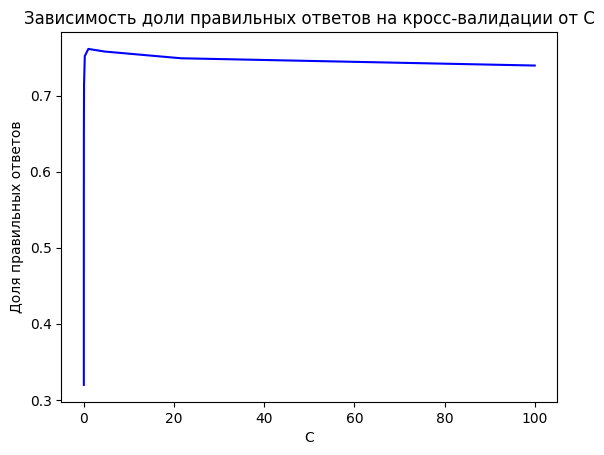

In [40]:
plt.plot(logit_c_values1, logit_mean_cv_scores1, color='blue')
plt.title('Зависимость доли правильных ответов на кросс-валидации от С')
plt.xlabel('С')
plt.ylabel('Доля правильных ответов')
plt.show()

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [41]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, 
                                            multi_class='multinomial', 
                                            cv=skf, random_state=17)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: total: 53.4 s
Wall time: 49.7 s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [42]:
logit_mean_cv_scores2 = np.mean(list(logit_grid_searcher2.scores_.values())[0], axis=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [43]:
best_accuracy_score2 = max(logit_mean_cv_scores2)
print('The best accuracy score: {}'.format(best_accuracy_score2))
best_c_value2 = logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores2)]
print('The best C value: {}'.format(best_c_value2))

The best accuracy score: 0.7616351102554001
The best C value: 1.9157894736842107


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

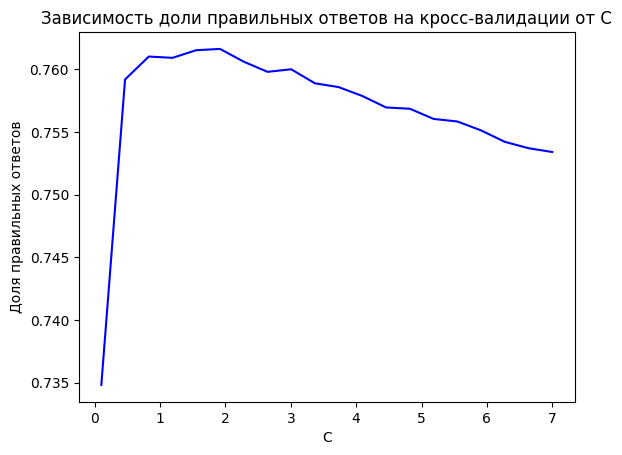

In [44]:
plt.plot(logit_c_values2, logit_mean_cv_scores2, color='blue')
plt.title('Зависимость доли правильных ответов на кросс-валидации от С')
plt.xlabel('С')
plt.ylabel('Доля правильных ответов')
plt.show()

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [45]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
print(logit_cv_acc)

0.7800426641384214


**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [46]:
logit_cv_cvs = cross_val_score(logit_grid_searcher2, X_train, y_train, 
                               cv=skf, scoring='accuracy').mean()
print('LogisticRegression with best C cross_val_score: {}'.format(logit_cv_cvs.mean()))
print('LogisticRegression with best C valid accuracy score: {}'.format(logit_cv_acc))

LogisticRegression with best C cross_val_score: 0.7606188191187001
LogisticRegression with best C valid accuracy score: 0.7800426641384214


In [47]:
answer4_3 = [round(x, 3) for x in [logit_cv_cvs, logit_cv_acc]]
write_answer_to_file(answer4_3, 'answer4_3.txt')

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [48]:
from sklearn.svm import LinearSVC

In [49]:
svm = LinearSVC(C=1, random_state=17)
svm_cross_val_score = cross_val_score(svm, X_train, y_train, 
                                      cv=skf, scoring='accuracy').mean()
print('SVM cross_val_score: {}'.format(svm_cross_val_score))

SVM cross_val_score: 0.7505606931259804


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [50]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}
svm_grid_searcher1 = GridSearchCV(svm, svm_params1, scoring='accuracy', 
                                  return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: total: 1min 5s
Wall time: 1min 5s


GridSearchCV(estimator=LinearSVC(C=1, random_state=17),
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             return_train_score=True, scoring='accuracy')

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [51]:
print('The best cross-validation accuracy score: {}'.format(svm_grid_searcher1.best_score_))
print('The best C value: {}'.format(svm_grid_searcher1.best_params_))

The best cross-validation accuracy score: 0.7054451209189594
The best C value: {'C': 3333.3334000000004}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

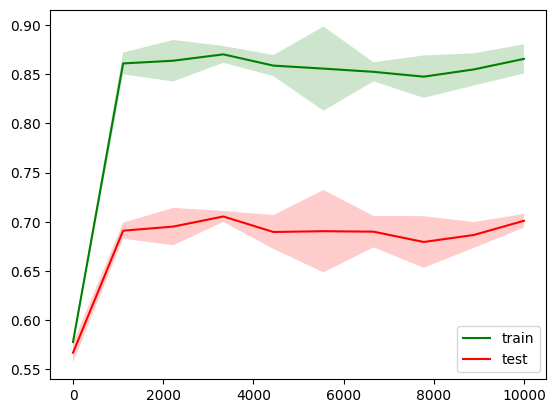

In [52]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [54]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}
svm_grid_searcher2 = GridSearchCV(svm, svm_params2, scoring='accuracy', 
                                  return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: total: 2min 5s
Wall time: 2min 6s


GridSearchCV(estimator=LinearSVC(C=1, random_state=17),
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             return_train_score=True, scoring='accuracy')

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [55]:
print('The best cross-validation accuracy score: {}'.format(svm_grid_searcher2.best_score_))
print('The best C value: {}'.format(svm_grid_searcher2.best_params_))

The best cross-validation accuracy score: 0.7700669317510849
The best C value: {'C': 0.10434482758620689}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

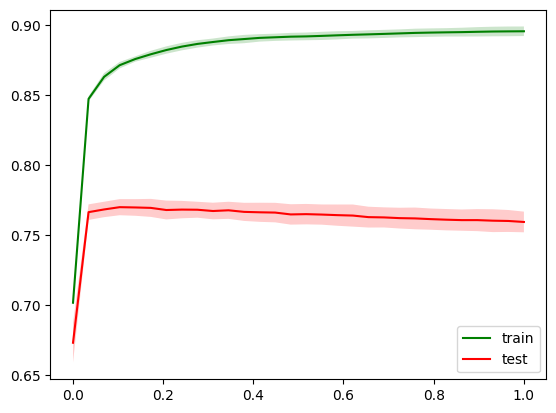

In [56]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [57]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.predict(X_valid))
print(svm_cv_acc)

0.7805167101208818


**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [58]:
svm_cv_cvs = cross_val_score(svm_grid_searcher2.best_estimator_, X_train, y_train, 
                             cv=skf, scoring='accuracy').mean()
print('SVM with the best C cross_val_score: {}'.format(svm_cv_cvs))
print('SVM with the best C valid accuracy score: {}'.format(svm_cv_acc))

SVM with the best C cross_val_score: 0.7670206386611259
SVM with the best C valid accuracy score: 0.7805167101208818


In [59]:
answer4_4 = [round(x, 3) for x in [svm_cv_cvs, svm_cv_acc]]
write_answer_to_file(answer4_4, 'answer4_4.txt')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [60]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as X_f:
        X_sparse = pickle.load(X_f)
    with open(path_to_y_pickle, 'rb') as y_f:
        y = pickle.load(y_f)
        
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, stratify=y, 
                                                          random_state=17, test_size=test_size)
    estimator_cvs = cross_val_score(estimator, X_train, y_train, 
                                    cv=cv, scoring='accuracy').mean()
    estimator.fit(X_train, y_train)
    estimator_valid_acc = accuracy_score(y_valid, estimator.predict(X_valid))
    
    return(estimator_cvs, estimator_valid_acc)

**Убедитесь, что функция работает.**

In [61]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7670206386611259, 0.7805167101208818)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [62]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [63]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, 
                                                                                         window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, 
                                                                                  window_size))
        print('session_length = {}\nwindow_size = {}'.format(session_length, 
                                                             window_size))
        res = [round(x, 3) for x in model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, cv=skf)]
        print('cross_val_score = {}, valid accuracy score = {}\n'.format(res[0], res[1]))

session_length = 15
window_size = 10
cross_val_score = 0.814, valid accuracy score = 0.833

session_length = 10
window_size = 10
cross_val_score = 0.767, valid accuracy score = 0.781

session_length = 15
window_size = 7
cross_val_score = 0.841, valid accuracy score = 0.845

session_length = 10
window_size = 7
cross_val_score = 0.786, valid accuracy score = 0.788

session_length = 7
window_size = 7
cross_val_score = 0.733, valid accuracy score = 0.742

session_length = 15
window_size = 5
cross_val_score = 0.858, valid accuracy score = 0.868

session_length = 10
window_size = 5
cross_val_score = 0.806, valid accuracy score = 0.815

session_length = 7
window_size = 5
cross_val_score = 0.752, valid accuracy score = 0.762

session_length = 5
window_size = 5
cross_val_score = 0.699, valid accuracy score = 0.707

CPU times: total: 15.1 s
Wall time: 15.3 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [65]:
res_10u_s15_w5 = model_assessment(svm_grid_searcher2.best_estimator_, 
                                  os.path.join(PATH_TO_DATA, 'X_sparse_10users_s15_w5.pkl'),
                                  os.path.join(PATH_TO_DATA, 'y_10users_s15_w5.pkl'), 
                                  skf, random_state=17, test_size=0.3)
answer4_5 = [round(x, 3) for x in res_10u_s15_w5]
write_answer_to_file(answer4_5, 'answer4_5.txt')

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [76]:
res_150u = model_assessment(svm_grid_searcher2.best_estimator_, 
                            os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'),
                            os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 
                            skf, random_state=17, test_size=0.3)

**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [77]:
answer4_6 = [round(x, 3) for x in res_150u]
write_answer_to_file(answer4_6, 'answer4_6.txt')

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [66]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [67]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [68]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs_[10]], multi_class='ovr', cv=skf,
                                         random_state=17, scoring='accuracy', n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: total: 2min 22s
Wall time: 3min 35s


LogisticRegressionCV(Cs=[3.7315789473684213],
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='ovr', n_jobs=-1, random_state=17,
                     scoring='accuracy')

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [70]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean()
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id]))

User 1, CV score: 0.996090206749867
User 2, CV score: 0.9963404335178755
User 3, CV score: 0.9952769697538395
User 4, CV score: 0.991784221117054
User 5, CV score: 0.9903766955470061
User 6, CV score: 0.9941926537591358
User 7, CV score: 0.9937339046844537
User 8, CV score: 0.9858830398381867
User 9, CV score: 0.9979564813945973
User 10, CV score: 0.9952978219845067
User 11, CV score: 0.994286488797139
User 12, CV score: 0.9936296435311167
User 13, CV score: 0.9968825915152273
User 14, CV score: 0.9947660901024887
User 15, CV score: 0.9963195812872083
User 16, CV score: 0.9963717118638766
User 17, CV score: 0.9907103312376843
User 18, CV score: 0.9944011760658097
User 19, CV score: 0.9944324544118107
User 20, CV score: 0.9912003586583675
User 21, CV score: 0.9805865732486733
User 22, CV score: 0.9969347220918957
User 23, CV score: 0.9948182206791572
User 24, CV score: 0.9910022624670275
User 25, CV score: 0.9965802341705503
User 26, CV score: 0.9943073410278064
User 27, CV score: 0.995

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [73]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = list()
total = class_distr.sum()

for user_id in np.unique(y_train_150):
    accuracy_cvs = cv_scores_by_user[user_id]
    classes_prop = (total - class_distr[user_id]) / total
    acc_diff_vs_constant.append(accuracy_cvs - classes_prop)
    
acc_diff_vs_constant=pd.Series(acc_diff_vs_constant)

In [74]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values)) > 0).sum()

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [75]:
answer4_7 = round(num_better_than_default / 150, 3)

with open('answer4_7.txt', 'w') as f:
    f.write(str(answer4_7))

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [78]:
y_binary_128 = np.array(y_train_150 == 128)

In [79]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [80]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_train_150, 
                                              y_binary_128, train_sizes=train_sizes, 
                                              cv=skf)

CPU times: total: 5.34 s
Wall time: 5.35 s


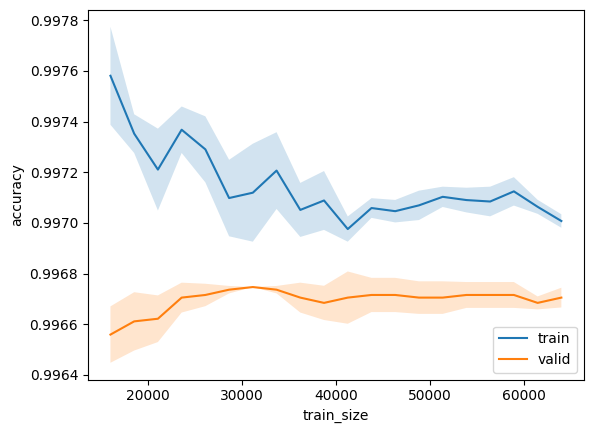

In [81]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.